## Introduction
So you just saw <a href='#'>NeighborGood</a> and picked a few cities that you liked based on your unique preferences. But while theoreticals are nice, you still want to visit them before deciding on your home-sweet-home. You have a week off of work this summer and you'd like to make the best of it. How can you squeeze in a visit to all those cities most efficiently?

## Traveling Salesman Problem
This is a classic example of a traveling salesmen problem. Although computationally difficult to truly optimize, there are established heuristics that provide a reasonably good solution. We will implement one of these, Christofides algorithm, below.

We begin by importing the required libraries, setting some styles, and defining the list of cities we want to visit.

In [1]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import time
import math
import shapefile


plt.style.use('ggplot')
cities = [(38.9071923, -77.0368707),
          (40.7127837, -74.0059413),
          (34.0522342, -118.2436849),
          (41.8781136, -87.6297982),
          (37.7749295, -122.4194155)]

## Supporting Functions
We will define a distance function that will be called many times throughout this project. It uses the Haversine formula and an approximation of Pi to provide a quick-and-dirty distance measurement (in kilometers) between two points on a globe.

In [2]:
def get_dist(p1, p2):
    """
    Returns Haversine distance (in km) between two lat/lon tuples.

    https://stackoverflow.com/questions/27928/calculate-distance-between-two-latitude-longitude-points-haversine-formula
    """
    r = 6384
    # Pi/180
    p = 0.017453292519943295
    a = 0.5 - math.cos((p2[0] - p1[0]) * p) / 2 + math.cos(p1[0] * p) * \
        math.cos(p2[0] * p) * (1 - math.cos((p2[1] - p1[1]) * p)) / 2
    return 2 * r * math.asin(math.sqrt(a))

## Christofides Algorithm
Algorithm:
1. Create minimum spanning tree of graph
2. Find all nodes with odd degree (odd number of edges)
3. Create minimum weight perfect matching graph of nodes from 2.
4. Combine graphs from 1. and 3. (all nodes should have even degree)
5. Remove (skip) repeated nodes

In [3]:
ts = time.time()
pos = {i: (p[1], p[0]) for i, p in enumerate(cities)}
edges = [(i, j, get_dist(p1, p2)) for i, p1 in enumerate(cities)
         for j, p2 in enumerate(cities)]
G = nx.Graph()
G.add_weighted_edges_from(edges)

# Step 1.
mst = nx.algorithms.minimum_spanning_tree(G)

# Step 2.
odds = [n for n in range(mst.number_of_nodes())
        if mst.degree(n) % 2 != 0]

# Step 3.
adj = np.array([[get_dist(pos[n1], pos[n2])
                 for n1 in odds] for n2 in odds])
# Prevent self-selection
np.fill_diagonal(adj, np.inf)
# Prevent re-selection of existing edges
for edge in mst.edges():
    if edge[0] in odds and edge[1] in odds:
        i = odds.index(edge[0])
        j = odds.index(edge[1])
        adj[i, j] = np.inf
        adj[j, i] = np.inf
new_edges = []
selected = []
# Find minimum weight edges
# np.argmin(adj, axis=1) includes duplicates, which we want to avoid
for indx, row in enumerate(adj):
    # If a node was selected already, skip it
    if indx in selected:
        continue
    min_indx = np.argmin(adj, axis=1)[indx]
    n1 = odds[indx]
    n2 = odds[min_indx]
    new_edges.append((n1, n2, adj[indx, min_indx]))
    # Prevent double selection
    # Overwrite columns with np.inf and add to selected list
    adj[:, indx] = np.inf
    adj[:, min_indx] = np.inf
    selected.extend((indx, min_indx))

# Step 4.
mm_mst = mst.copy()
mm_mst.add_weighted_edges_from(new_edges)

# Step 5.
p_node = 0
n_node = 0
nodelist = [n_node]
edgelist = []
edgestack = []
while len(nodelist) < len(mm_mst.nodes()):
    for edge in mm_mst.edges(n_node):
        edgestack.insert(0, edge)
    while n_node in nodelist:
        n_node = edgestack.pop(0)[1]
    nodelist.append(n_node)
    edgelist.append((p_node, n_node))
    p_node = n_node
tsp_edges = [(e[0], e[1], get_dist(pos[e[0]], pos[e[1]]))
             for e in edgelist]
wrap = (nodelist[-1], nodelist[0], get_dist(pos[nodelist[-1]],
                                            pos[nodelist[0]]))
tsp_edges.append(wrap)
tsp = nx.DiGraph()
tsp.add_weighted_edges_from(tsp_edges)

te = time.time()
print('Christofides complete in {0} sec'.format(te - ts))

Christofides complete in 0.003341197967529297 sec


## Route Improvement
The route generated via Christofides is not necessarily optimal. In fact, if you see crossed edges in the graph then you know that it is sub-optimal. Fortunately, there are also heuristics for route improvement, one of which is the 2-opt algorithm.
### 2-opt Algorithm
Algorithm:
1. Select a pair of nodes, i and k, along a given route
2. Take route[0] to route[i-1] and add them in order to new_route
3. Take route[i] to route[k] and add them in reverse order to new_route
4. Take route[k] to end of route and add them in order to new_route
5. If new_route is shorter than route, then route becomes new_route
6. Go back to 1. and repeat with new selection of nodes

two_opt() called 2 times


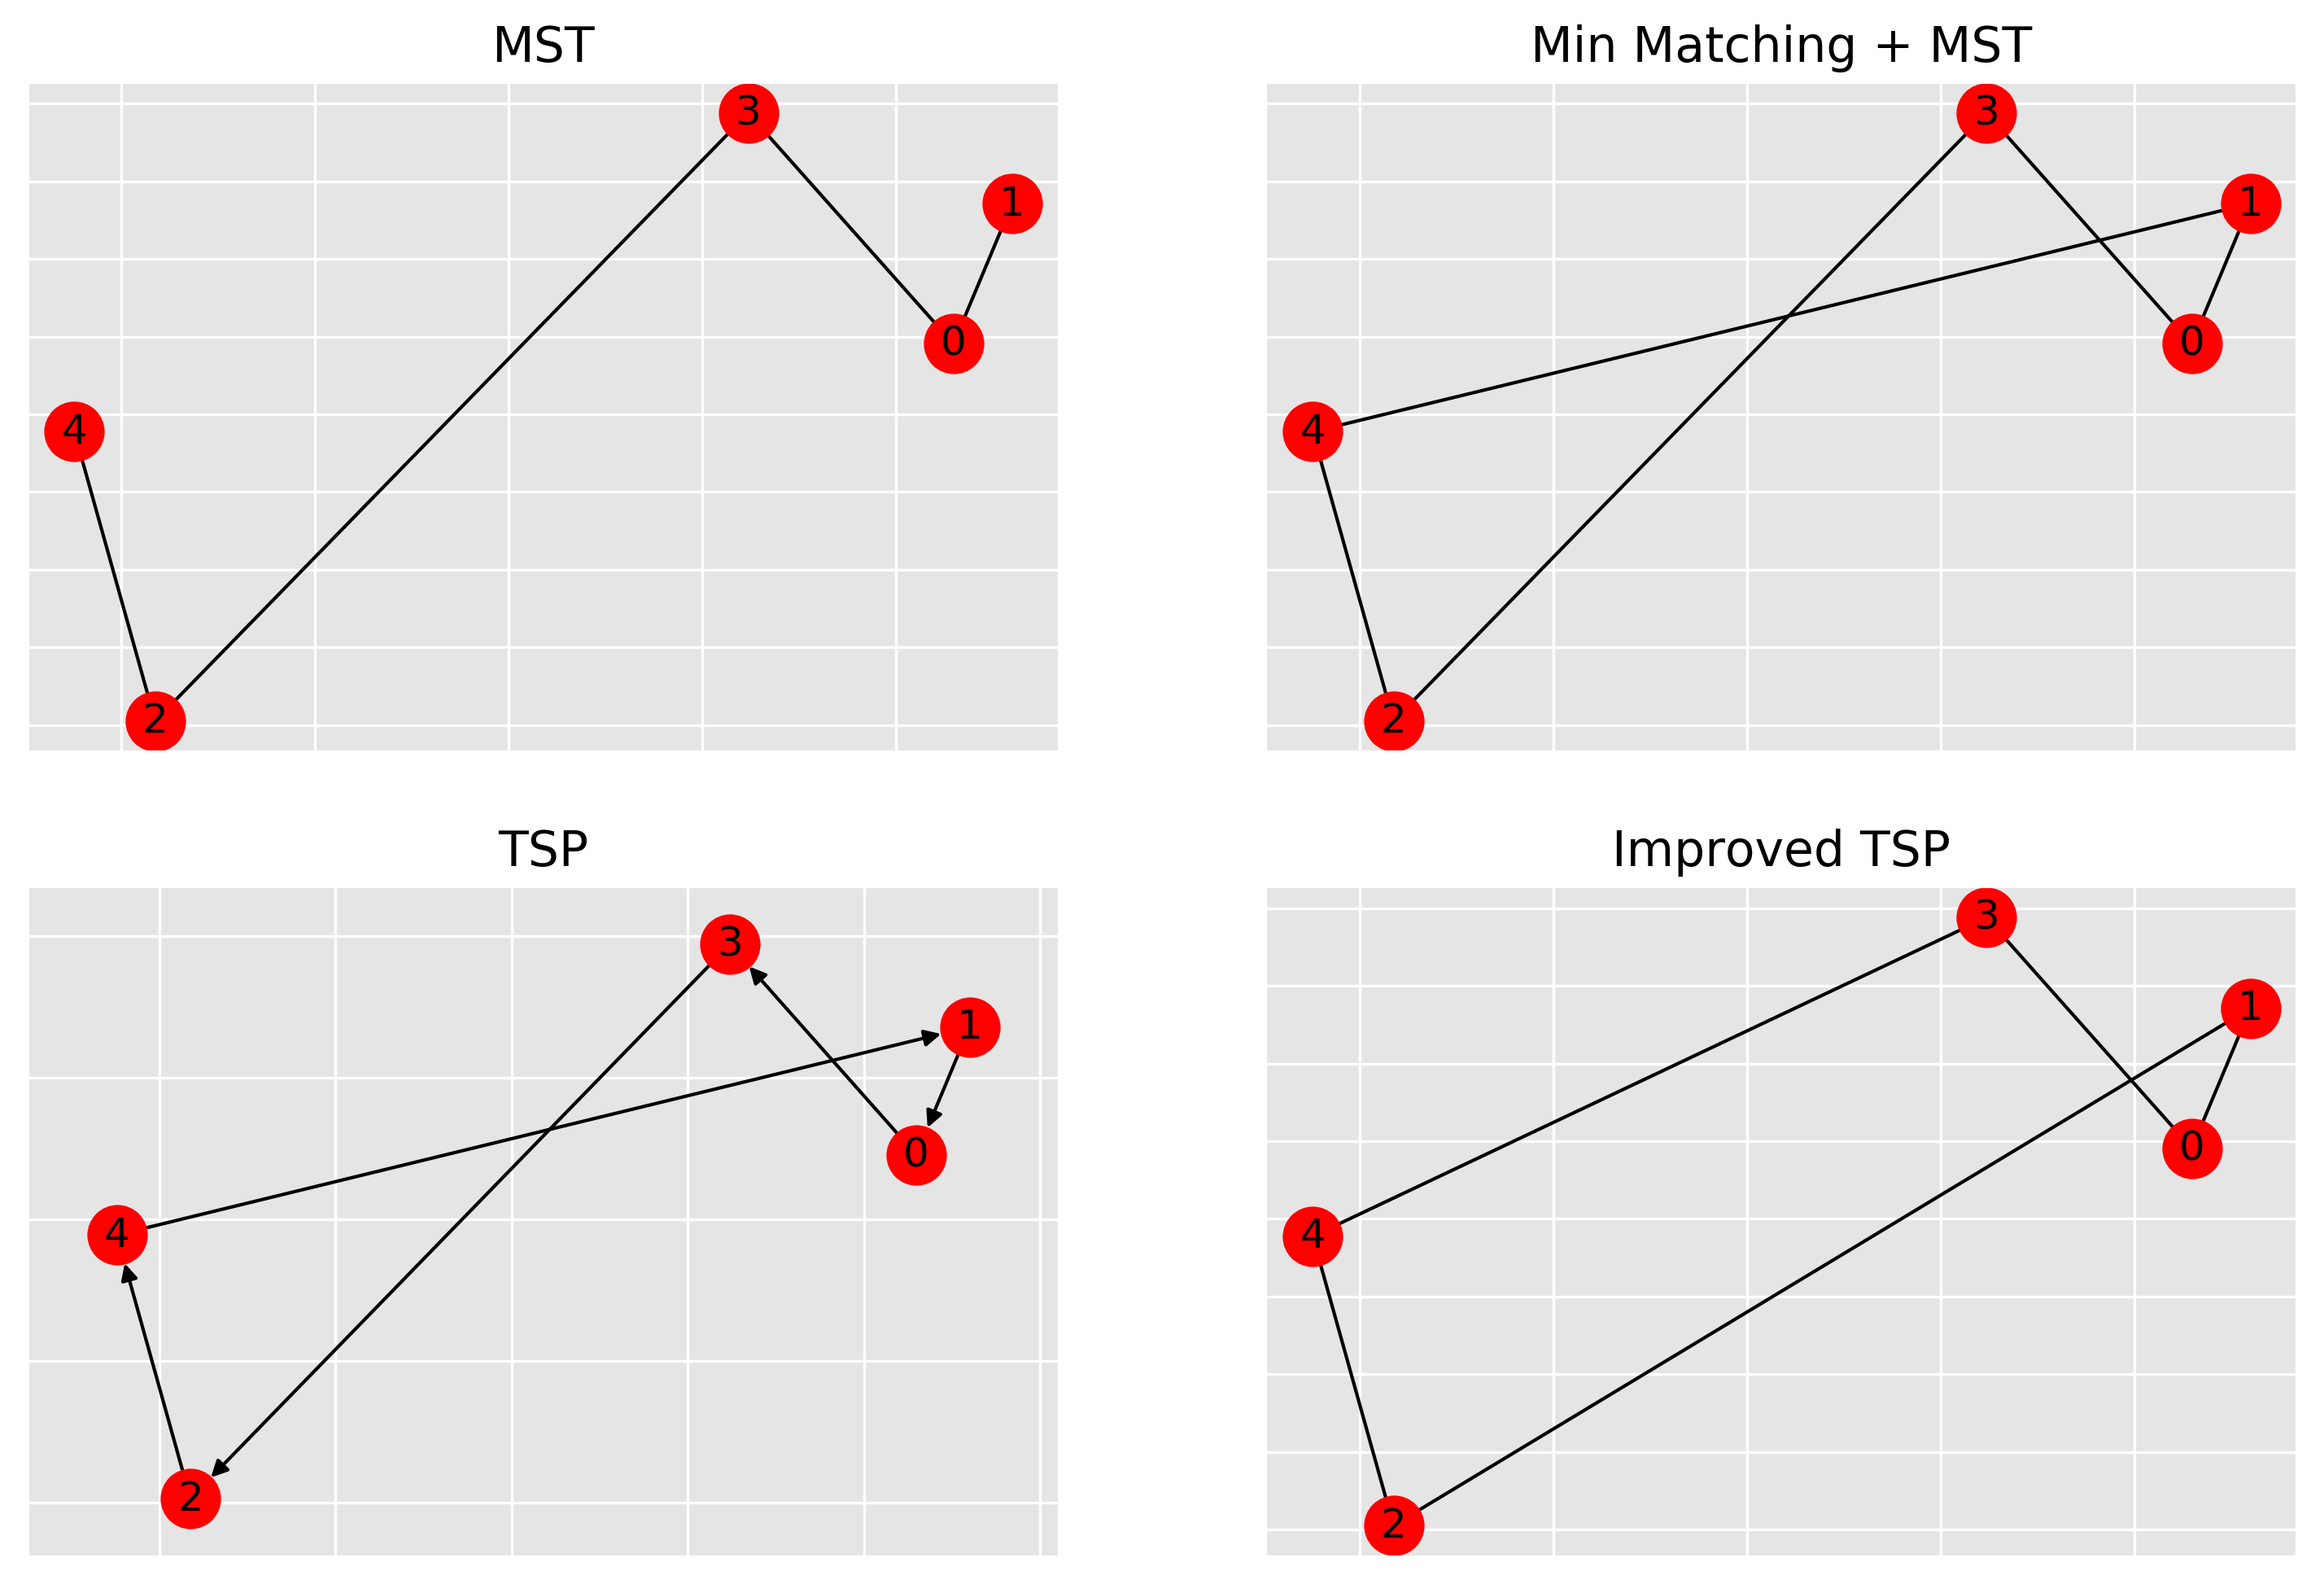

In [4]:
def valid_route(route):
    """
    Returns False if the route has sub-tours or same-node edges.
    """
    edges = []
    for edge in route:
        if edge[0] == edge[1]:
            return False
        if len(edges) > 0 and edge[0] != edges[-1][1]:
            return False
        edges.append(edge)
    return True

def swap(route, i, j):
    new_route = route[:i]
    new_route.append((route[i][0], route[j][0]))
    for indx in range(j - 1, i, -1):
        edge = route[indx]
        new_route.append((edge[1], edge[0]))
    new_route.append((route[i][1], route[j][1]))
    new_route += route[j + 1:]
    return new_route
    
def two_opt(graph, pos):
    route = list(graph.edges())
    dist = sum([get_dist(pos[e[0]], pos[e[1]]) for e in route])
    i1 = 0
    while i1 < len(route) - 2:
        i2 = i1 + 1
        while i2 < len(route):
            new_route = swap(route, i1, i2)
            new_dist = sum([get_dist(pos[e[0]], pos[e[1]])
                            for e in new_route])
            if new_dist < dist and valid_route(new_route):
                route = new_route
                dist = new_dist
                i1 = 0
                break
            i2 += 1
        i1 += 1
    edges = [(e[0], e[1], get_dist(pos[e[0]], pos[e[1]]))
             for e in route]
    tsp = nx.Graph()
    tsp.add_weighted_edges_from(edges)
    return tsp

old = tsp.copy()
two_opt_ctr = 0
while True:
    new = two_opt(old, pos)
    if list(new.edges()) == list(old.edges()):
        break
    old = new.copy()
    two_opt_ctr += 1
print('two_opt() called {0} times'.format(two_opt_ctr))
improved_tsp = new.copy()

# Draw all steps as subplots
fig = plt.figure(figsize=(12, 8), dpi=300)
ax = fig.add_subplot(221)
ax.set_title('MST')
ax.tick_params(axis='both', which='both', bottom='off',
               top='off', labelbottom='off', right='off',
               left='off', labelleft='off')
nx.draw_networkx(mst, pos=pos)
ax = fig.add_subplot(222)
ax.set_title('Min Matching + MST')
ax.tick_params(axis='both', which='both', bottom='off',
               top='off', labelbottom='off', right='off',
               left='off', labelleft='off')
nx.draw_networkx(mm_mst, pos=pos)
ax = fig.add_subplot(223)
ax.set_title('TSP')
ax.tick_params(axis='both', which='both', bottom='off',
               top='off', labelbottom='off', right='off',
               left='off', labelleft='off')
nx.draw_networkx(tsp, pos=pos)
ax = fig.add_subplot(224)
ax.set_title('Improved TSP')
ax.tick_params(axis='both', which='both', bottom='off',
               top='off', labelbottom='off', right='off',
               left='off', labelleft='off')
nx.draw_networkx(improved_tsp, pos=pos)

## Visualization
With some <a href='https://chrishavlin.wordpress.com/2016/11/16/shapefiles-tutorial/'>help</a>, we can draw a map of the US with our route overlaid.

Another option would be to use something like Mapbox's API to generate a map of the US and overlay our route onto that.

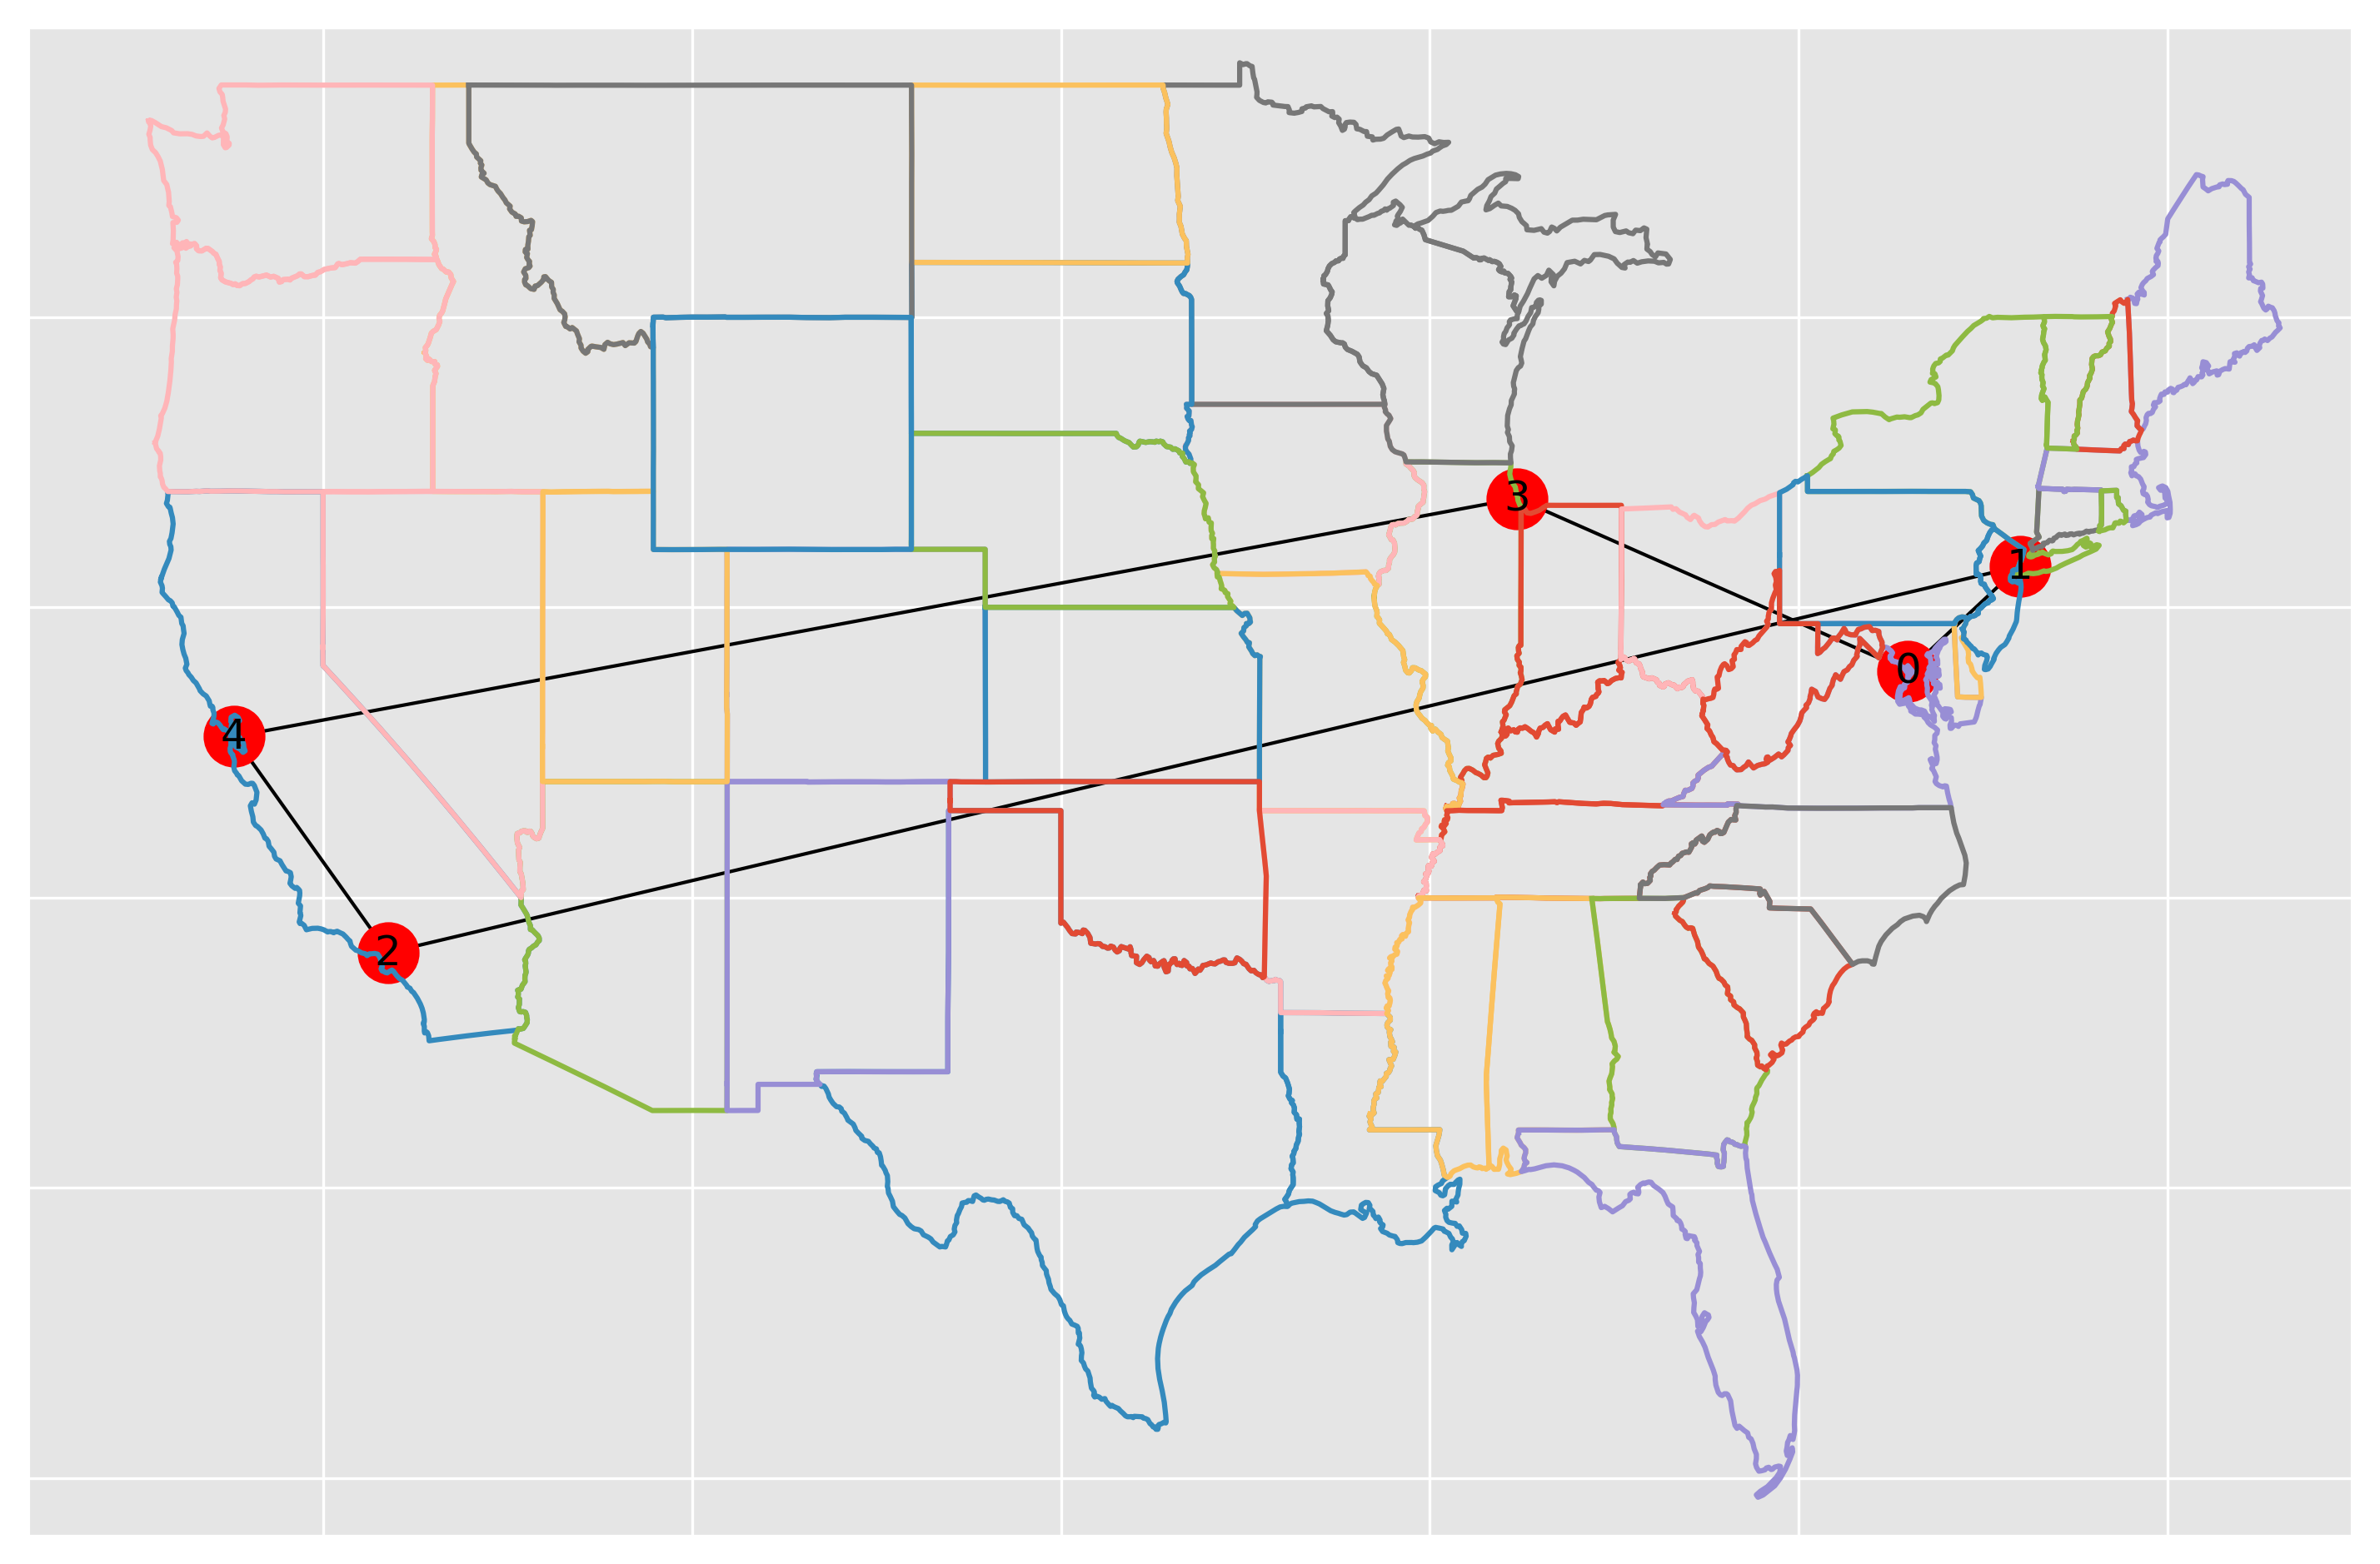

In [5]:
fig = plt.figure(figsize=(12, 8), dpi=300)
ax = fig.add_subplot(111)
ax.tick_params(axis='both', which='both', bottom='off',
               top='off', labelbottom='off', right='off',
               left='off', labelleft='off')
sf = shapefile.Reader('cb_2017_us_state_20m/cb_2017_us_state_20m.shp')
for shape in list(sf.iterShapes()):
    npoints=len(shape.points) # total points
    nparts = len(shape.parts) # total parts
    if nparts == 1:
        x_lon = np.zeros((len(shape.points), 1))
        y_lat = np.zeros((len(shape.points), 1))
        for ip in range(len(shape.points)):
            x_lon[ip] = shape.points[ip][0]
            y_lat[ip] = shape.points[ip][1]
        plt.plot(x_lon,y_lat)

    else: # loop over parts of each shape, plot separately
        for ip in range(nparts): # loop over parts, plot separately
            i0=shape.parts[ip]
            if ip < nparts-1:
                i1 = shape.parts[ip+1]-1
            else:
                i1 = npoints

        seg=shape.points[i0:i1+1]
        x_lon = np.zeros((len(seg),1))
        y_lat = np.zeros((len(seg),1))
        for ip in range(len(seg)):
            x_lon[ip] = seg[ip][0]
            y_lat[ip] = seg[ip][1]

        plt.plot(x_lon,y_lat)

plt.xlim(-128,-65)
plt.ylim(24,50)
nx.draw_networkx(improved_tsp, pos=pos)
plt.show()